In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cvxpy as cvx
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [15]:
class portfolioSelection(object):

    def __init__(self, means, covMatrix, wheights=[], shorting=False, constraints=[]):

        self.means = means
        self.covMatrix = covMatrix
        if not wheights:
            self.weights = np.ones(len(means)) * (1/len(self.means))
        else:
            self.weights = wheights
        if not shorting:
            self.bounds = ((0,1),)
            for i in range(len(means)-1):
                self.bounds = ((0,1),) + self.bounds
        else:
            self.bounds = ()
        if not constraints:
            self.constraints = ({'type': 'eq', 'fun': self.sum},)
        else:
            self.constraints = constraints

    def sum(self, weights):
        return np.sum(weights) -1

    def getSharpeRatio(self, weights):
        self.weights = np.array(weights)
        self.returns = np.dot(self.weights, self.means)
        self.volatility = np.sqrt(np.dot(weights.T, np.dot(self.covMatrix, self.weights)))
        self.sharpeRatio = (self.returns - 100) / self.volatility
        return self.sharpeRatio*-1

    def getVolatility(self, weights):
        weights = np.array(weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(self.covMatrix, weights)))
        return volatility
    
    def getReturns(self, weights):
        weights = np.array(weights)
        returns = np.dot(weights, self.means)
        return returns

    def SharpeOptimize(self):
        opt = minimize(self.getSharpeRatio, self.weights, method='SLSQP', bounds=self.bounds, constraints=self.constraints)
        return opt.x
    
    def volatilityOptimizer(self, goalMean):
        self.constraints = ({'type': 'eq', 'fun': lambda w: self.getReturns(w) - goalMean},) + self.constraints
        return minimize(self.getVolatility, self.weights, method='SLSQP', bounds=self.bounds, constraints=self.constraints)

In [16]:
def backtest(stockPerformance, portfolio='shorting', windowSize=100, target=1.00275, initialValue=100):
    weights = np.zeros((len(stockPerformance) - windowSize, len(stockPerformance.columns)))
    portfolioValues = np.zeros(len(stockPerformance) - windowSize)
    portfolioReturns = np.zeros(len(stockPerformance) - windowSize)
    tickers = stockPerformance.columns

    for i in range(len(portfolioValues)):

        estWindow = stockPerformance.iloc[i : windowSize + i, :26]
        current_week = stockPerformance.iloc[windowSize + i, :26]
        means = estWindow.mean()
        volatilities = estWindow.std()
        corr = estWindow.corr()
        
        # cvx
        Variables = cvx.Variable(26)
        sigma = np.diag(volatilities) @ corr @ np.diag(volatilities)
        cvxFunction = cvx.quad_form(Variables, sigma)
        one = np.ones(26,)

        # Constraints
        if portfolio == 'shorting':
            constraints = [Variables @ one == 1, Variables.T @ means == target]
        elif portfolio == 'noShorting':
            constraints = [Variables @ one == 1, Variables.T @ means == target, Variables >= 0]
        elif portfolio == 'equal':
            constraints = [Variables @ one == 1, Variables == cvx.sum(Variables)/26]
        
        cvxProblem = cvx.Problem(cvx.Minimize(cvxFunction), constraints)
        cvxProblem.solve()
        try:
            weights[i, :] = Variables.value.round(10)
        except AttributeError:
            if np.mean(means) > target:
                weights[i, :] = np.where(means.index == means.idxmin(), 1, 0)
            elif np.mean(means) < target:
                weights[i, :] = np.where(means.index == means.idxmax(), 1, 0)
        portfolioReturns[i] = weights[i, :] @ current_week

        if i == 0:
            portfolioValues[i] = portfolioReturns[i] * initialValue
        else:
            portfolioValues[i] = portfolioReturns[i] * portfolioValues[i - 1]

    weightsDF = {}
    for i in range(len(tickers)):
        weightsDF[tickers[i]] = weights[:,i]
    weightsDF = pd.DataFrame(weightsDF)

    return np.insert(portfolioValues, 0, initialValue), portfolioReturns, weightsDF

In [17]:
def getTrackingError(mu, stockMeans, var, wights, covStocks, covSaP, V0=100, R0=1):

    ones = np.ones(len(stockMeans))

    weightsTrackingError = (((mu-R0)*V0 - wights.T @ (stockMeans - R0*ones)) /
                            (((stockMeans - R0*ones).T @ np.linalg.inv(covStocks) @
                            (stockMeans - R0*ones))) * np.linalg.inv(covStocks) @
                            (stockMeans - R0 * ones) + wights)

    trackingError = np.sqrt(weightsTrackingError.T @ covStocks @ weightsTrackingError - 2 *
                    weightsTrackingError.T @ covSaP + var*10000)

    return weightsTrackingError, trackingError


In [18]:
#### Import data
data = pd.read_csv('Dow_SP500_9620_weekly.csv', parse_dates=True, sep=';')
dfStockReturns = data[data.columns[1:27]].pct_change().dropna()
dfStockGrossReturns = 100+dfStockReturns*100
dfStockperformance = dfStockGrossReturns/100                            
dfStockLogReturns = np.log(data[data.columns[1:27]]).diff().dropna()

# data to np
stocks = dfStockLogReturns.columns.tolist()
npData = dfStockLogReturns.to_numpy()

<h1>1. The Mean-Volatility Diagram</h1>
<h2>a)-c) Mean-Volatility Diagram with Efficient Frontiers and Sharpe portfolio:</h2>

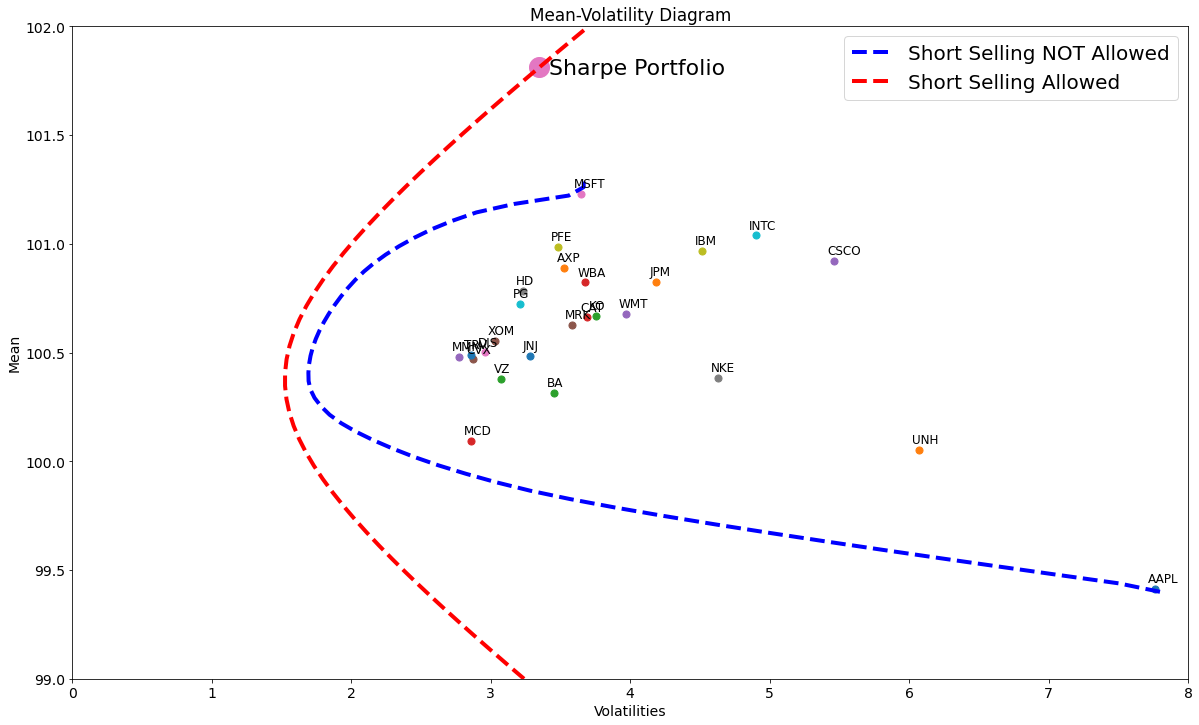

In [19]:
# a) calculate return and variance for first 100 weeks

covMatrix = dfStockGrossReturns.iloc[:100].cov()
means = np.zeros(len(stocks))
volatilities = np.zeros(len(stocks))

for i in range(len(stocks)):
    means[i] = np.mean(100*np.exp(npData[:100,:][:,i]))
    volatilities[i] = np.std(100*np.exp(npData[:100,:][:,i]))


# b) calculate frontiers

yLimit = np.linspace(99.4, 101.3, 50)
yLimitShorting = np.linspace(99, 102, 50)

returns = []
returnsShorting = []

for possible_return in yLimit:
    frontier = portfolioSelection(means, covMatrix)
    result = frontier.volatilityOptimizer(possible_return)
    returns.append(result['fun'])

for possible_return in yLimitShorting:
    frontier = portfolioSelection(means, covMatrix, shorting=True)
    result = frontier.volatilityOptimizer(possible_return)
    returnsShorting.append(result['fun'])


# c) Calculate Sharpe Portfolio

sharpe = portfolioSelection(means, covMatrix, shorting=True)
sharpeWheights = sharpe.SharpeOptimize()

# plot
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots()
axs.set_xlabel('Volatilities')
axs.set_ylabel('Mean')
axs.set_title('Mean-Volatility Diagram')
axs.set_xlim(0,8)
axs.set_ylim(99,102)

# Stocks
plt.rcParams.update({'font.size': 12})
for i in range(len(stocks)):
    axs.scatter(volatilities[i], means[i], s = 50)
    axs.text(volatilities[i]-0.05, means[i]+0.03, stocks[i])

# Frontiers
axs.plot(returns, yLimit, 'b--', linewidth=4, label='Short Selling NOT Allowed')
axs.plot(returnsShorting, yLimitShorting, 'r--', linewidth=4, label='Short Selling Allowed')

#Sharpe
# axs.plot(sharpe.volatility, sharpe.returns, marker='D', markersize=15, markerfacecolor='r', label='Sharpe portfolio (with shorting)')

plt.rcParams.update({'font.size': 22})
axs.scatter(sharpe.volatility, sharpe.returns, s=400)
axs.text(sharpe.volatility+0.07, sharpe.returns-0.03, 'Sharpe Portfolio')

axs.legend(prop={'size': 20})
plt.show()

<h2>d) Plot the Sharpe allocation as a bar plot</h2>

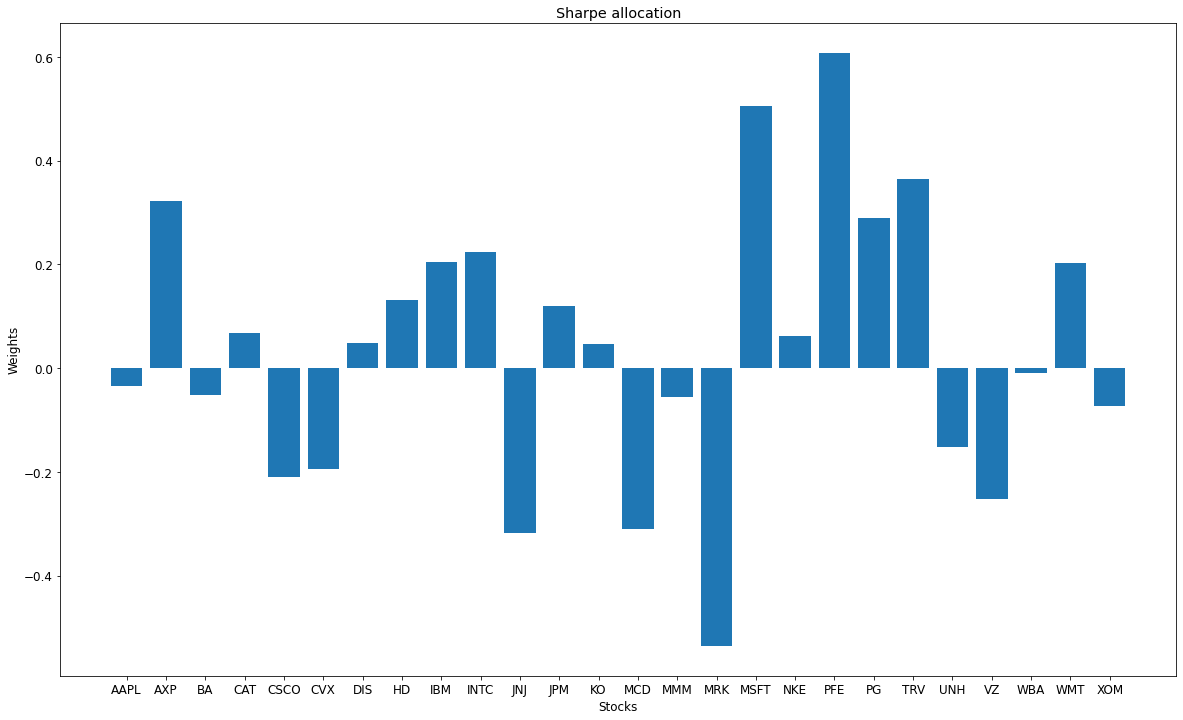

In [20]:
# d) Display Sharpe Wheights
plt.rcParams.update({'font.size': 12})
plt.bar(stocks, sharpeWheights)
plt.title('Sharpe allocation')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.show()

<h2>e) Gross Return Correlations:<h2>

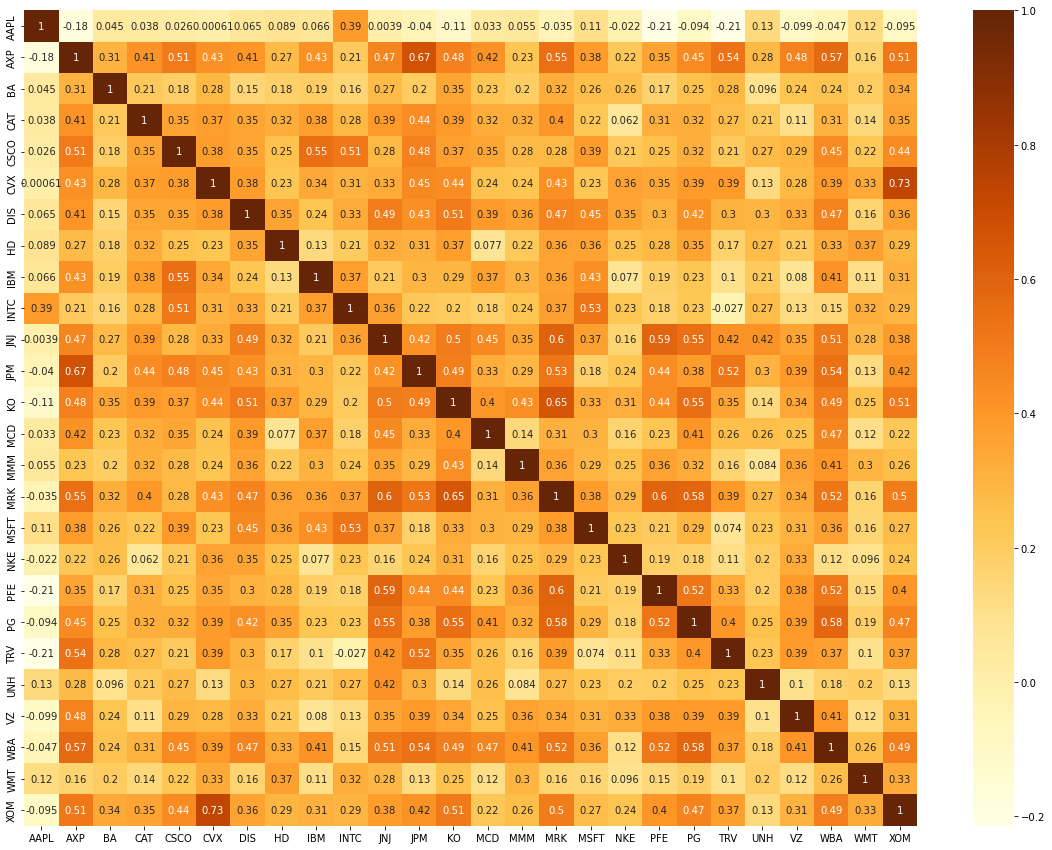

In [21]:
# calculate correlation and covariance for first 100 weeks
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [20, 15]
corrMatrix = dfStockGrossReturns.iloc[:100].corr()
sn.heatmap(corrMatrix, annot=True,cmap="YlOrBr")
plt.show()

<h3>Discussion</h3>
Looking at above Mean-Volatility Diagram Apple seems to be by far the worst investment of the stocks displayed.<br>
It seem to have lowest return and highest volatility.

<h1>2. Backtesting the standard Markowitz model</h1>

In [22]:
# Run Backtest:
shortingPortfolioValues, shortingPortfolioReturns, shortingWeightsDF = backtest(dfStockperformance)

noShortingPortfolioValues, noShortingPortfolioReturns, noShortingWeightsDF = backtest(dfStockperformance, portfolio='noShorting')

equalPortfolioValues, equalPortfolioReturns, equalWeightsDF = backtest(dfStockperformance, portfolio='equal')

<h2>a) Plot the evolution of the portfolios in the same plot.</h2>

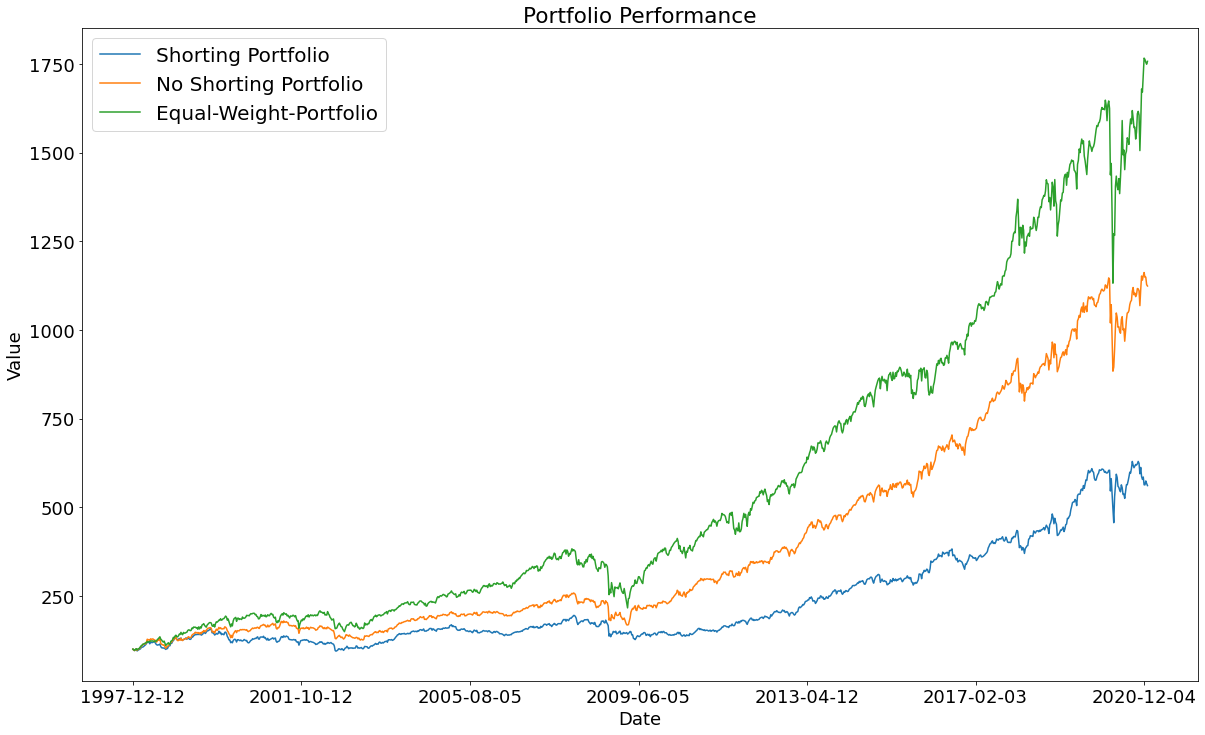

In [23]:
dates = data.iloc[100:, :]['Date'].values
performance = {
    'Shorting Portfolio': shortingPortfolioValues,
    'No Shorting Portfolio': noShortingPortfolioValues,
    'Equal-Weight-Portfolio': equalPortfolioValues
    }
performance = pd.DataFrame(performance, index = dates)

plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})
performance.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Portfolio Performance")
plt.legend(prop={'size': 20})
plt.show()

<h2>b) Include a table with the portfolio values at every 100th week, beginning at week 0.</h2>

In [24]:
index = np.linspace(0,1200,13).astype(int)
table = performance.iloc[index].round(2)
tableindex = []
for i in range(13):
    tableindex.append(f'Week {index[i]}')
table.index = tableindex
table

,Shorting Portfolio,No Shorting Portfolio,Equal-Weight-Portfolio
Week 0,100.00,100.00,100.00
Week 100,142.32,152.85,176.01
Week 200,124.44,159.32,182.08
Week 300,121.52,151.64,202.33
Week 400,151.29,198.91,265.87
Week 500,172.42,240.09,370.63
Week 600,136.01,223.59,304.27
Week 700,161.50,311.41,478.85
Week 800,236.02,435.91,641.32
Week 900,290.66,552.92,864.74


<h2>c) Calculate annualized means, volatilities, Sharpe ratios, maximum drawdown and average ENCs for the
portfolios’ weekly percentage returns over the backtesting period.</h2>

In [25]:
shortingAnnualReturn = np.mean(shortingPortfolioReturns - 1) * 52
noShortingAnnualReturn = np.mean(noShortingPortfolioReturns - 1) * 52
equalAnnualReturn = np.mean(equalPortfolioReturns - 1) * 52

shortingAnnualVol = np.std(shortingPortfolioReturns - 1) * np.sqrt(52)
noShortingAnnualVol = np.std(noShortingPortfolioReturns - 1) * np.sqrt(52)
equalAnnualVol = np.std(equalPortfolioReturns - 1) * np.sqrt(52)


shortmdd = shortingPortfolioValues - np.maximum.accumulate(shortingPortfolioValues)
shortmddPrc = np.min(shortmdd/np.maximum.accumulate(shortingPortfolioValues))

noShortmdd = noShortingPortfolioValues - np.maximum.accumulate(noShortingPortfolioValues)
noShortmddPrc = np.min(noShortmdd/np.maximum.accumulate(noShortingPortfolioValues))

equalmdd = equalPortfolioValues - np.maximum.accumulate(equalPortfolioValues)
equalmddPrc = np.min(equalmdd/np.maximum.accumulate(equalPortfolioValues))


shortENC = np.zeros(len(shortingWeightsDF.to_numpy()))
noShortENC = np.zeros(len(noShortingWeightsDF.to_numpy()))
equalENC = np.zeros(len(equalWeightsDF.to_numpy()))
for i in range(len(shortENC)):
    shortENC[i] = 1/np.sum(np.square(shortingWeightsDF.to_numpy())[i])
    noShortENC[i] = 1/np.sum(np.square(noShortingWeightsDF.to_numpy())[i])
    equalENC[i] = 1/np.sum(np.square(equalWeightsDF.to_numpy())[i])
    
# print(
#     shortingAnnualReturn,
#     noShortingAnnualReturn,
#     equalAnnualReturn
# )
# print(
#     shortingAnnualVol,
#     noShortingAnnualVol,
#     equalAnnualVol
# )
# print(
#     shortingAnnualReturn/shortingAnnualVol,
#     noShortingAnnualReturn/noShortingAnnualVol,
#     equalAnnualReturn/equalAnnualVol
# )
# print(
#     shortmddPrc,
#     noShortmddPrc,
#     equalmddPrc
# )
# print(
#     np.mean(shortENC),
#     np.mean(noShortENC),
#     np.mean(equalENC)
# )

|  | Shorting Portfolio | No Shorting Portfolio | Equal-Weight-Portfolio | 
| --- | --- | --- | --- |
| Annualized means | 0.087 | 0.116 | 0.140 |
| Annualized volatility | 0.159 | 0.151 |  0.175 |
| Sharpe Ratio | 0.548 | 0.768 | 0.797 |
| Maximum Drawdown [%] | 40.62 | 34.92 | 43.54 |
| Average ENC | 2.954 | 5.975 | 26.00 |

<h2>d) Plot the portfolio percentage weights for the no short target portfolio using the area plot.
</h2>

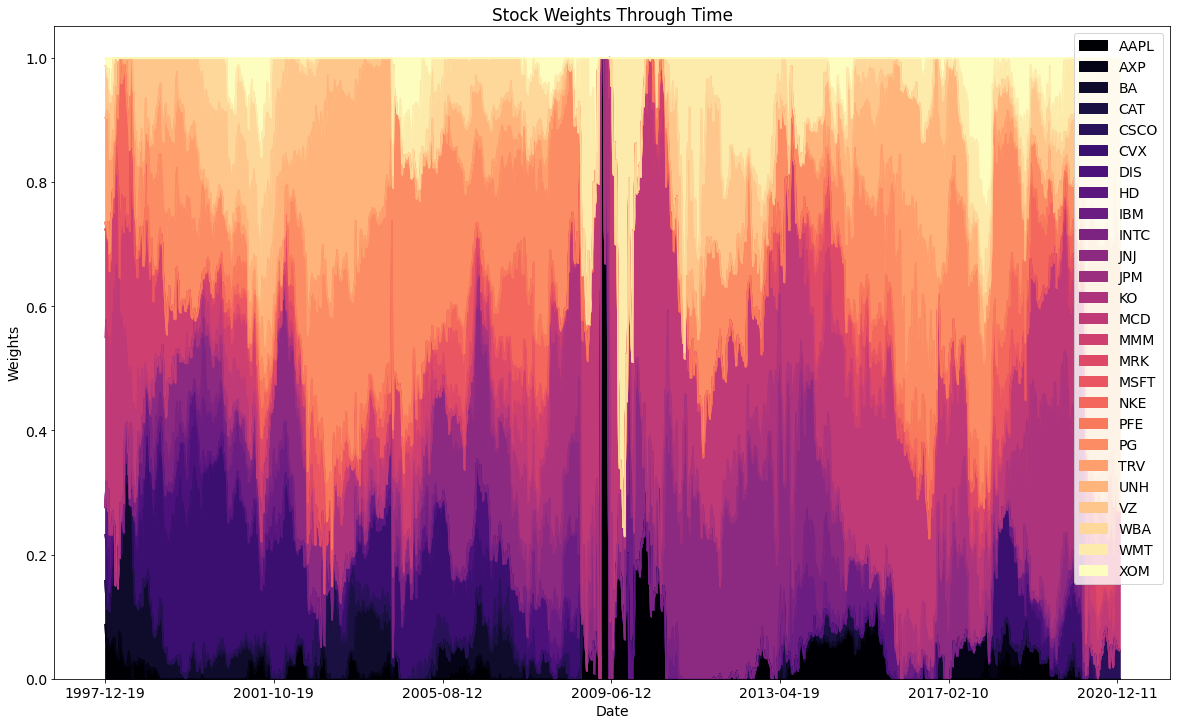

In [26]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 14})
df = noShortingWeightsDF.clip(lower=0)
df.index = data.iloc[-len(noShortingWeightsDF):, :]['Date'].values
df.plot.area(colormap="magma")
plt.title('Stock Weights Through Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.show()

<h3>Discussion:</h3>
Comparing the portfolios we can see that the Equal-Weight Portfolio performs the best in terms of return and sharpe ratio. <br>
The Markowitz portfolios have slightly lower volatilities, logically hence we want to balnce with respect to the negative correlations. <br>
However, the small positive (lower volatility) does not (even close) outweigh the loss in return, which aligns with equal wight portfolio having the best sharpe ratio. <br>
Also, a negative for the equal weight portfolio is that the maximum drawdown is slightly above the other portfolios.<br>
however the Equal-Weight Portfolio is the most diversified as measuerd by ENC and should be least sencitive for a large crash in one stock. <br>
If for example the Markowitz model with shorting allowed are unfortunate and tally the wrong stock at the wrong time, the consequence might be devistating. <br>
<br>
Further, the plot in d) displays a large varaiation in wheights of the stocks, which would result in huge transactional costs in practicallity.



<h1>3. Benchmark allocation</h1>


<h2>a) Plot the optimal hedge portfolio allocation as a bar plot and include the values in a table</h2>

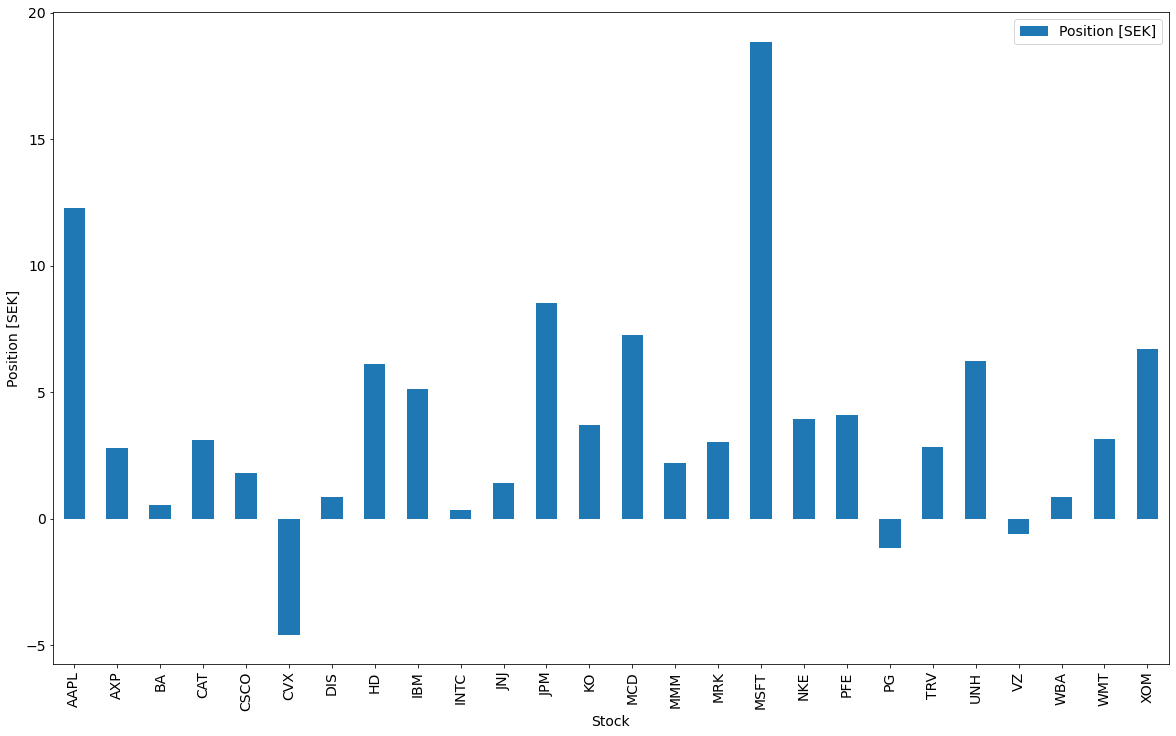

,Position [SEK]
AAPL,12.293926
AXP,2.786133
BA,0.551621
CAT,3.101097
CSCO,1.802340
CVX,-4.589231
DIS,0.868999
HD,6.109077
IBM,5.113470
INTC,0.350396


In [27]:
window = data.iloc[-101:,1:]
window = window / window.shift(1)
window = window.dropna()

cov = window.cov()
covSaP = cov.iloc[26,:26] * 100
covStocks = cov.iloc[:26, :26]

# %%
weights = (np.linalg.inv(covStocks) @ covSaP)
weights = pd.DataFrame(weights, index = covStocks.columns, columns=['Position [SEK]'])


# %%
weights.plot.bar()
plt.xlabel('Stock')
plt.ylabel('Position [SEK]')
plt.show()
weights

<h2>c) What is the smallest tracking error that can be achieved? </h2>

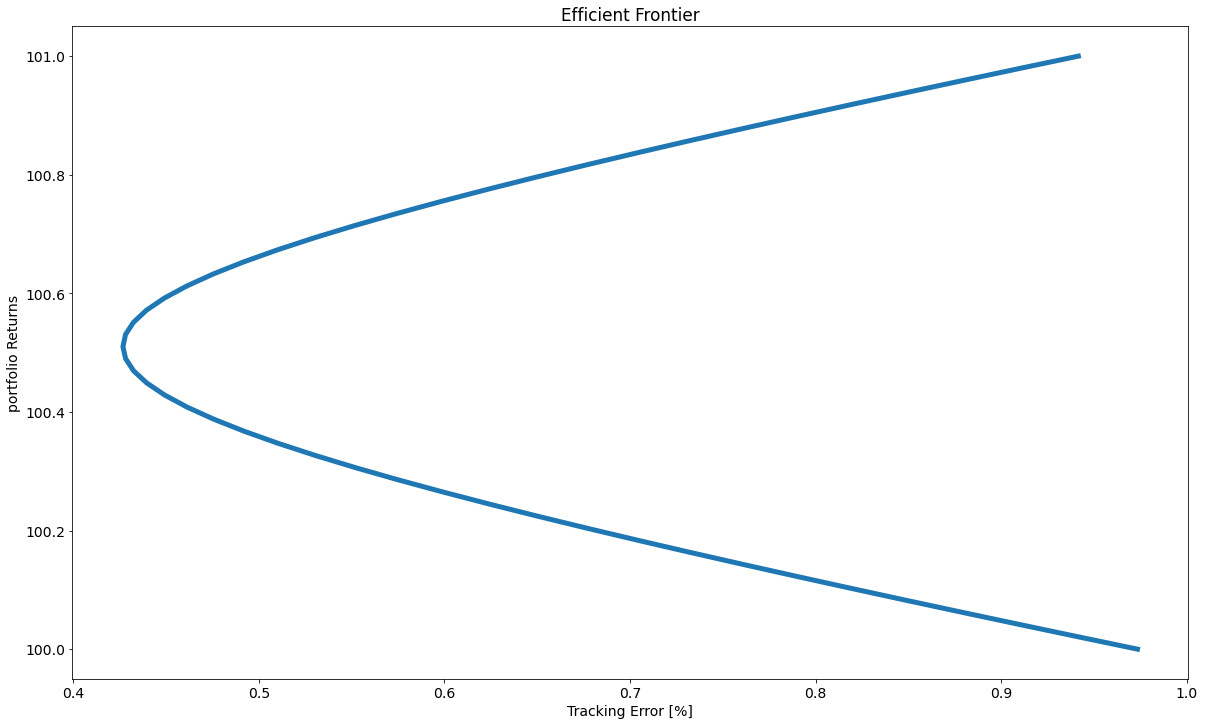

In [28]:
# Parameters TrackingErrorrs:
V0 = 100
stockWindow = window.iloc[:,:-1]
weightsNumpy = weights['Position [SEK]'].to_numpy().T
var = window.iloc[:,-1].var()
stockMeans = np.mean(stockWindow)

mus = np.linspace(1, 1.01, 50)
trackingErrors = np.zeros((len(mus)))
portfolioReturns = np.zeros((len(mus)))

for i, mu in enumerate(mus):
    weight, trackingErrors[i] = getTrackingError(mu, stockMeans, var, weightsNumpy, covStocks, covSaP)
    V = V0 - weight.T @ np.ones(len(stockMeans))
    portfolioReturns[i] = weight @ stockMeans + V

# %%
plt.plot(trackingErrors, portfolioReturns, linewidth=5)
plt.title('Efficient Frontier')
plt.ylabel('portfolio Returns')
plt.xlabel('Tracking Error [%]')
plt.show()

<h2>d) What is the expected excess return (in excess of S&P500) of the minimum tracking error portfolio?</h2>

In [30]:
minTrackingError = np.min(trackingErrors)
imin = np.argmin(trackingErrors)

# print(minTrackingError)
# print(portfolioReturns[imin] - np.mean(window.iloc[:,-1])*V0)

| Portfolio Measurement | Value |
| --- | --- |
| min Tracking Error | 42.7% |
| Alpha/Excess Return (in relation to benchmark) | 0.133 |